In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [87]:
df = None
df_split = None
df_plot = None

# file_name = 'data_0129_154443.csv'
# file_name = 'data_0129_154901.csv'
file_name = 'data_0129_163213.csv'


df = pd.read_csv(f'../Data/raw_data/{file_name}', sep=',')

# Split the data into columns
df[['Cycle','Position','Reading']] = df['Data'].str.split(':', expand=True)
df.drop(columns=['Data','Index'], inplace=True)

# Clean 
df.dropna(inplace=True)

# Convert the data types
df['Cycle'] = df['Cycle'].astype(int)
df['Position'] = df['Position'].astype(int)
df['Reading'] = df['Reading'].astype(float)



df.head()


,Cycle,Position,Reading
1,0,-1,26.00
2,0,-7,26.32
3,0,-13,26.35
4,0,-20,26.19
5,0,-26,26.19


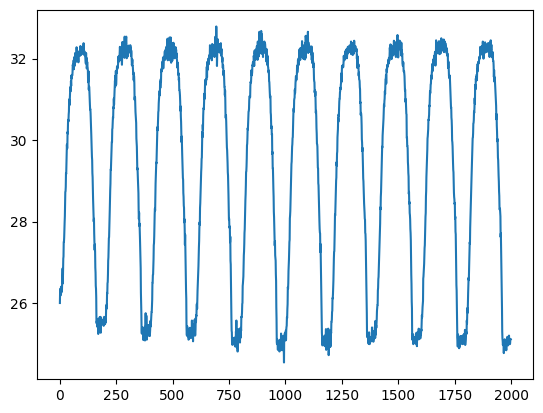

In [88]:
# df.plot(x='Cycle', y='Reading',c='Position',colormap='jet', kind='scatter')
# plt.scatter(df.index, df['Reading'], c=df['Position'], cmap='viridis',s=3)
plt.plot(df.index, df['Reading'])

In [89]:
df['Position_Gradient'] = np.gradient(df['Position'])
df['Direction'] = df['Position_Gradient'] > 0
df.head()

,Cycle,Position,Reading,Position_Gradient,Direction
1,0,-1,26.00,-6.0,False
2,0,-7,26.32,-6.0,False
3,0,-13,26.35,-6.5,False
4,0,-20,26.19,-6.5,False
5,0,-26,26.19,-6.5,False


,Cycle,Position,Reading,Position_Gradient,Direction
1995,9,0,24.99,0.0,False
1996,9,0,25.01,0.0,False
1997,9,0,25.11,0.0,False
1998,9,0,25.12,0.0,False
1999,9,0,25.11,0.0,False


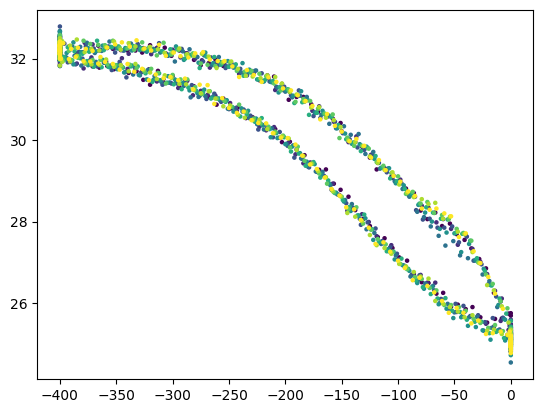

In [93]:
df_plot = df[df['Cycle'] >= 1]
plt.scatter(df_plot['Position'], df_plot['Reading'], c=df_plot['Cycle'], cmap='viridis',s=5)
df_plot.tail()